In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc

In [2]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import  metrics 
from sklearn.model_selection import cross_validate, GridSearchCV

In [3]:
trainset = pd.read_csv('Data\credit_card_default_train.csv', index_col='Client_ID' )
testset = pd.read_csv('Data\credit_card_default_test.csv', index_col='Client_ID' )

In [4]:
trainset['Balance_Limit_V1'] = trainset['Balance_Limit_V1'].replace({'K': '*1e3', 'M': '*1e6'}, regex=True).map(pd.eval).astype(int)
testset['Balance_Limit_V1'] = testset['Balance_Limit_V1'].replace({'K': '*1e3', 'M': '*1e6'}, regex=True).map(pd.eval).astype(int)

In [5]:
testset = testset.sort_values('Client_ID')

In [6]:
trainset

,Balance_Limit_V1,Gender,EDUCATION_STATUS,MARITAL_STATUS,AGE,PAY_JULY,PAY_AUG,PAY_SEP,PAY_OCT,PAY_NOV,...,DUE_AMT_OCT,DUE_AMT_NOV,DUE_AMT_DEC,PAID_AMT_JULY,PAID_AMT_AUG,PAID_AMT_SEP,PAID_AMT_OCT,PAID_AMT_NOV,PAID_AMT_DEC,NEXT_MONTH_DEFAULT
Client_ID,,,,,,,,,,,,,,,,,,,,,
A2,1000000,M,Graduate,Other,31-45,-1,-1,-1,-1,-1,...,39418,162772,-13982,3437,6004,39418,162772,0,538165,0
A3,1000000,F,High School,Other,Less than 30,0,-1,-1,-1,-1,...,43530,80811,124590,151818,46200,43530,80811,942,33666,0
A4,100000,F,High School,Single,31-45,4,3,2,2,-2,...,0,0,0,0,0,0,0,0,0,1
A5,200000,F,Graduate,Single,31-45,2,0,0,0,0,...,97309,100353,102740,3855,3890,3696,4620,4049,3918,1
A6,1000000,F,Graduate,Other,31-45,2,2,0,0,0,...,435354,445271,453899,0,20790,16170,17325,16401,17325,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A29996,1000000,F,High School,Single,31-45,0,0,0,0,0,...,203289,72157,36914,19635,46200,11557,7039,11550,2310,0
A29997,400000,F,High School,Other,31-45,-1,-1,-1,-1,0,...,20741,11989,0,4243,8145,20785,298,0,0,0
A29998,100000,F,Other,Other,31-45,4,3,2,-1,0,...,48228,47544,44715,0,0,50820,9702,4620,7161,1


In [8]:
trainset.dtypes

Balance_Limit_V1       int32
Gender                object
EDUCATION_STATUS      object
MARITAL_STATUS        object
AGE                   object
PAY_JULY               int64
PAY_AUG                int64
PAY_SEP                int64
PAY_OCT                int64
PAY_NOV                int64
PAY_DEC                int64
DUE_AMT_JULY           int64
DUE_AMT_AUG            int64
DUE_AMT_SEP            int64
DUE_AMT_OCT            int64
DUE_AMT_NOV            int64
DUE_AMT_DEC            int64
PAID_AMT_JULY          int64
PAID_AMT_AUG           int64
PAID_AMT_SEP           int64
PAID_AMT_OCT           int64
PAID_AMT_NOV           int64
PAID_AMT_DEC           int64
NEXT_MONTH_DEFAULT     int64
dtype: object

In [7]:
encode_columns = ['AGE']
encode_df = trainset[encode_columns]
encode_df = encode_df.astype('str')
le = LabelEncoder()
encode_df = encode_df.apply(le.fit_transform)
score_encode_drop = trainset.drop(encode_columns, axis = 1)
score_encode = pd.concat([score_encode_drop, encode_df], axis = 1)

In [9]:
encode_df_test = testset[encode_columns]
encode_df_test = encode_df_test.astype('str')
encode_df_test = encode_df_test.apply(le.fit_transform)
score_encode_drop_test = testset.drop(encode_columns, axis = 1)
score_encode_test = pd.concat([score_encode_drop_test, encode_df_test], axis = 1)


In [10]:
onehot_columns =  ['MARITAL_STATUS', 'EDUCATION_STATUS', 'Gender']
onehot_df = score_encode[onehot_columns]
onehot_df = pd.get_dummies(onehot_df, columns = onehot_columns)
score_onehot_drop = score_encode.drop(onehot_columns, axis = 1)
score_onehot = pd.concat([score_onehot_drop, onehot_df], axis = 1)

In [11]:
onehot_df_test = score_encode_test[onehot_columns]
onehot_df_test = pd.get_dummies(onehot_df_test, columns = onehot_columns)
score_onehot_drop_test = score_encode_test.drop(onehot_columns, axis = 1)
score_onehot_test = pd.concat([score_onehot_drop_test, onehot_df_test], axis = 1)

In [ ]:
New = score_onehot.drop(['Gender_M', 'MARITAL_STATUS_Other','Gender_F','EDUCATION_STATUS_Other','EDUCATION_STATUS_High School','EDUCATION_STATUS_Graduate','MARITAL_STATUS_Single','AGE'], axis=1)

In [12]:
train_all, test_all = train_test_split(score_onehot, test_size=0.30, random_state=42)

In [13]:
from sklearn.metrics import f1_score
def f1score(m, train, test, predictorsnew): 
    predictions_lgbm_01 = np.where(m.predict(train[predictorsnew]) > 0.5, 1, 0)
    predictions_lgbm_02 = np.where(m.predict(test[predictorsnew]) > 0.5, 1, 0)
    return (f1_score(train[target],predictions_lgbm_01),f1_score(test[target],predictions_lgbm_02))

In [14]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['NEXT_MONTH_DEFAULT'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['NEXT_MONTH_DEFAULT'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['NEXT_MONTH_DEFAULT'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

    return alg

In [15]:
def get_metrics(true_labels, predicted_labels):
    print('Accuracy:', np.round(metrics.accuracy_score(true_labels,predicted_labels),2))
    print('Precision:', np.round(metrics.precision_score(true_labels,predicted_labels),2))
    print('Recall:', np.round(metrics.recall_score(true_labels,predicted_labels),2))
    print('F1 Score:', np.round(metrics.f1_score(true_labels,predicted_labels),2))

In [16]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

In [17]:
target = 'NEXT_MONTH_DEFAULT'
IDcol = 'Client_ID'
predictors = [x for x in score_onehot.columns if x not in [target, IDcol]]


Model Report
Accuracy : 0.8315
AUC Score (Train): 0.827799


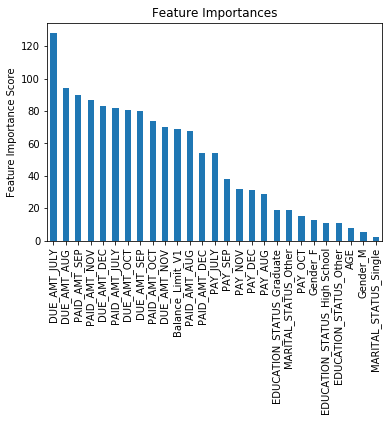

In [18]:
model = modelfit(xgb1, train_all, predictors)

Accuracy: 0.83
Precision: 0.74
Recall: 0.38
F1 Score: 0.51


<Figure size 432x288 with 0 Axes>

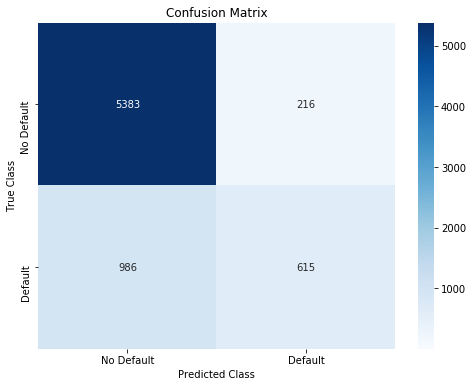

In [24]:
#Print Confusion Matrix
predictions_lgbm_02 = np.where(model.predict(test_all[predictors]) > 0.5, 1, 0)
get_metrics(test_all[target],predictions_lgbm_02)
plt.figure()
cm = confusion_matrix(test_all[target], predictions_lgbm_02)
labels = ['No Default', 'Default']
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()


Model Report
Accuracy : 0.83
AUC Score (Train): 0.819911


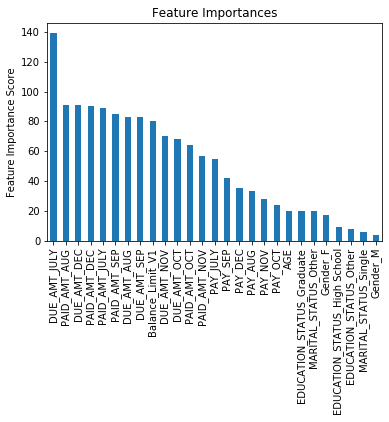

In [25]:
#training for the whole dataset
model = modelfit(xgb1, score_onehot, predictors)

In [26]:
df2 = pd.DataFrame()
df2['Client_ID'] = testset.index
df2['NEXT_MONTH_DEFAULT'] = pd.DataFrame(model.predict(score_onehot_test[predictors]))
df2.set_index('Client_ID', inplace=True)
df2.to_csv('out2.csv')